## 1. 사용할 패키지 불러오기

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
%cd '/content/drive/MyDrive/kmong/car_number'

/content/drive/MyDrive/kmong/car_number


In [37]:
import sys
sys.path.append('/content/gdrive/MyDrive/kmong/car_number/data_gen')

In [38]:
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import json
from data_gen.data_gen import PointInferenceDatasetGenerator, ClassInferenceDatasetGenerator
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

## 2. 데이터 불러오기

### (1) target Data 경로 지정

In [39]:
img_path = "/content/drive/MyDrive/kmong/car_number/target_data/"

### (2) target Data 불러오기

In [40]:
img_list = os.listdir(img_path)
img_list = sorted(img_list)
img_list = [os.path.join(img_path, img) for img in img_list]

## 3. 모델링

In [41]:
save_path = "/content/drive/MyDrive/kmong/car_number/cropped_dataset/target"
os.makedirs(save_path, exist_ok=True)

### (1) Dataloader 생성

In [42]:
dataset = PointInferenceDatasetGenerator(img_list)
dataloader = dataset.dataloader()

### (2) 학습된 Point Prediction Model 불러오기

In [43]:
model_name = 'resnet18'
vision_model = models.resnet18(pretrained=True)
num_ftrs = vision_model.fc.in_features
vision_model.fc = nn.Linear(num_ftrs, 8)
vision_model.load_state_dict(torch.load('result/Best_model.pth',map_location=torch.device('cpu')))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

### (3) Point 예측에 대한 Crop

In [44]:
print('Prediction')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in dataloader['test']:
        images, width, height, original_image, fname = data['image'].float().to(device), data['width'].float(), data['height'].float(), data['original_image'].float(), data['fname']
        images = images.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.cpu().numpy()
        horizen_min = min(pred[0][0], pred[0][2], pred[0][4], pred[0][6])
        horizen_max = max(pred[0][0], pred[0][2], pred[0][4], pred[0][6])
        vertical_min = min(pred[0][1], pred[0][3], pred[0][5], pred[0][7])
        vertical_max = max(pred[0][1], pred[0][3], pred[0][5], pred[0][7])
        horizen_min = int(horizen_min / 448 * height)
        horizen_max = int(horizen_max / 448 * height)
        vertical_min = int(vertical_min / 224 * width)
        vertical_max = int(vertical_max / 224 * width)
        print(horizen_min,horizen_max,vertical_min,vertical_max)
        cropped_image = np.array(original_image)[0, :, :, :][vertical_min:vertical_max, horizen_min:horizen_max, :]
        save_fname = os.path.join(save_path, fname[0])
        cv2.imwrite(save_fname, cropped_image)
        





Prediction
117 1983 340 889
97 1375 88 693


### (4) Crop_Dataloader 생성

In [45]:
img_path_crop = "/content/drive/MyDrive/kmong/car_number/cropped_dataset/target"

In [46]:
img_list_crop = os.listdir(img_path_crop)
img_list_crop = sorted(img_list_crop)
img_list_crop = [os.path.join(img_path_crop, img) for img in img_list_crop]

In [47]:
dataset_crop = ClassInferenceDatasetGenerator(img_list_crop)
dataloader_crop = dataset_crop.dataloader()

### (5) 학습된 Class Prediction Model 불러오기

In [48]:
model_name = 'resnet18'
vision_model = models.resnet18(pretrained=True)
num_ftrs = vision_model.fc.in_features
uni_label = ['1996_n', '2004_n', '2006_eu', '2006_n', '2006_us', '2019_n', '2019_r', 'bike', 'echo']
vision_model.fc = nn.Linear(num_ftrs, len(uni_label))
vision_model.load_state_dict(torch.load('result/Classification_Best_model.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

### (6) Class 예측

In [49]:
print('Test Prediction')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in dataloader_crop['test']:
        images = data['image'].float().to(device)
        images = images.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.argmax(dim=1, keepdim = False)
        pred = list(pred.cpu().numpy())
        predictions = predictions + pred

Test Prediction


In [50]:
predictions = [uni_label[i] for i in predictions]

In [51]:
print(predictions)

['2006_n', 'echo']


# 교체할 이미지 불러오기

In [52]:
sample_img_path = "/content/drive/MyDrive/kmong/car_number/sample_data/"


sample_img_list = os.listdir(sample_img_path)
sample_img_list = sorted(sample_img_list)
sample_img_list = [os.path.join(sample_img_path, img) for img in sample_img_list]

In [53]:
sample_img_list_np=[]

for i in sample_img_list:
    img = Image.open(i)
    img_array = np.array(img)
    sample_img_list_np.append(img_array)
    print(i, " 추가 완료 - 구조:", img_array.shape) # 불러온 이미지의 차원 확인 (세로X가로X색)
    #print(img_array.T.shape) #축변경 (색X가로X세로)

/content/drive/MyDrive/kmong/car_number/sample_data/1996_n.PNG  추가 완료 - 구조: (86, 170, 4)
/content/drive/MyDrive/kmong/car_number/sample_data/2004_n.PNG  추가 완료 - 구조: (95, 187, 4)
/content/drive/MyDrive/kmong/car_number/sample_data/2006_eu.PNG  추가 완료 - 구조: (53, 238, 4)
/content/drive/MyDrive/kmong/car_number/sample_data/2006_n.PNG  추가 완료 - 구조: (38, 183, 4)
/content/drive/MyDrive/kmong/car_number/sample_data/2006_us.PNG  추가 완료 - 구조: (110, 228, 4)
/content/drive/MyDrive/kmong/car_number/sample_data/2019_n.PNG  추가 완료 - 구조: (46, 202, 4)
/content/drive/MyDrive/kmong/car_number/sample_data/2019_r.PNG  추가 완료 - 구조: (49, 213, 4)
/content/drive/MyDrive/kmong/car_number/sample_data/bike.PNG  추가 완료 - 구조: (82, 162, 4)
/content/drive/MyDrive/kmong/car_number/sample_data/echo.PNG  추가 완료 - 구조: (33, 158, 4)


# class predict 진행 후 예측결과에따라 교체할 이미지 선정

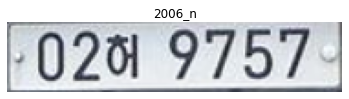

In [54]:
clss = predictions[0]
if clss == "1996_n":

  plt.title(clss)   # title 
  plt.imshow(sample_img_list_np[0])
  plt.axis('off')
  img_mix = sample_img_list_np[0]
  num = 0

elif clss == "2004_n":

  plt.title(clss)   # title 
  plt.imshow(sample_img_list_np[1])
  plt.axis('off')
  img_mix = sample_img_list_np[1]
  num = 1

elif clss == "2006_eu":

  plt.title(clss)   # title 
  plt.imshow(sample_img_list_np[2])
  plt.axis('off')
  img_mix = sample_img_list_np[2]
  num = 2

elif clss == "2006_n":

  plt.title(clss)   # title 
  plt.imshow(sample_img_list_np[3])
  plt.axis('off')
  img_mix = sample_img_list_np[3]
  num = 3

elif clss == "2006_us":

  plt.title(clss)   # title 
  plt.imshow(sample_img_list_np[4])
  plt.axis('off')
  img_mix = sample_img_list_np[4]
  num = 4

elif clss == "2019_n":

  plt.title(clss)   # title 
  plt.imshow(sample_img_list_np[5])
  plt.axis('off')
  img_mix = sample_img_list_np[5]
  num = 5

elif clss == "2019_r":

  plt.title(clss)   # title )
  plt.imshow(sample_img_list_np[6])
  plt.axis('off')
  img_mix = sample_img_list_np[6]
  num = 6


elif clss == "bike":

  plt.title(clss)   # title )
  plt.imshow(sample_img_list_np[7])
  plt.axis('off')
  img_mix = sample_img_list_np[7]
  num = 7

else:

  plt.title(clss)   # title 
  plt.imshow(sample_img_list_np[8])
  plt.axis('off')
  img_mix = sample_img_list_np[8]
  num = 8


plt.show()  

# Original 사진 불러오기

In [55]:
img_list_np=[]

for i in img_list:
    img = Image.open(i)
    img_array = np.array(img)
    img_list_np.append(img_array)
    print(i, " 추가 완료 - 구조:", img_array.shape) # 불러온 이미지의 차원 확인 (세로X가로X색)
    #print(img_array.T.shape) #축변경 (색X가로X세로)

/content/drive/MyDrive/kmong/car_number/target_data/05서6452.jpg  추가 완료 - 구조: (1185, 2108, 3)
/content/drive/MyDrive/kmong/car_number/target_data/29거6831.jpg  추가 완료 - 구조: (835, 1485, 3)


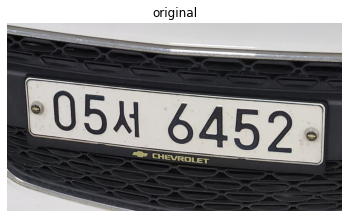

In [56]:
origin_img = img_list_np[0]

plt.title("original")   # title 
plt.imshow(origin_img)
plt.axis('off')


plt.show()

# 교체할 사진 불러오기

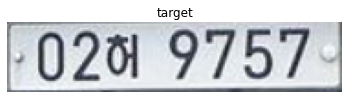

In [57]:
plt.title("target")   # title 
plt.imshow(img_mix)
plt.axis('off')


plt.show()

In [58]:
from google.colab.patches import cv2_imshow

src1 = cv2.imread(img_list[0]) 
src2 = cv2.imread(sample_img_list[num]) 

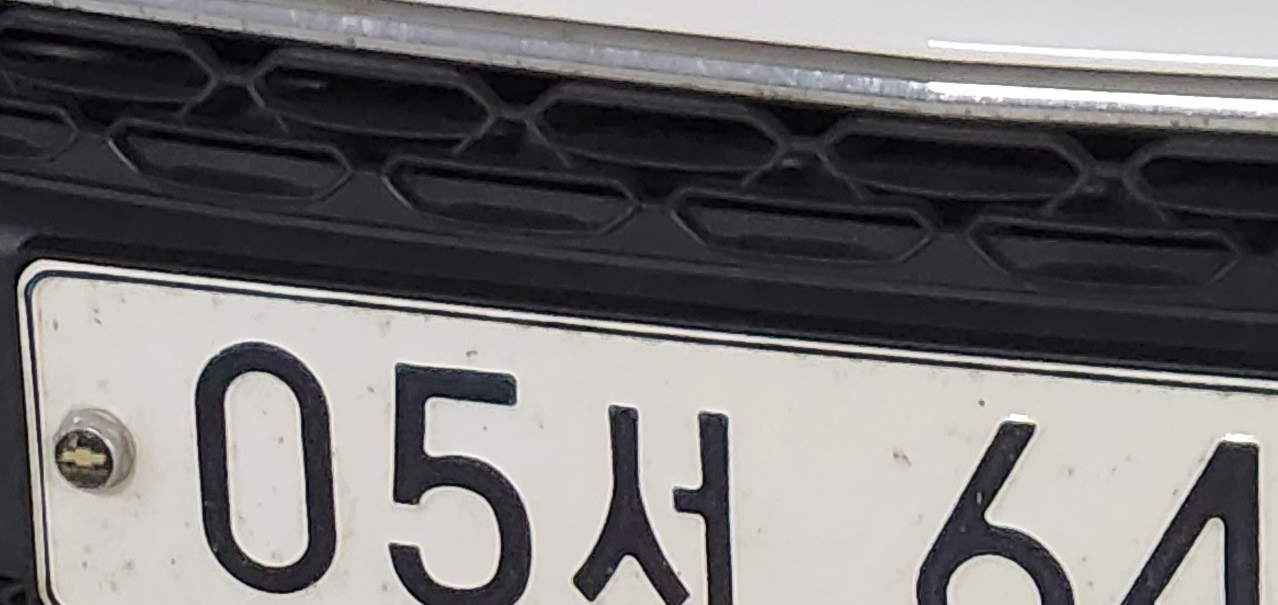

In [59]:
output = src1[vertical_min:vertical_max,horizen_min:horizen_max]

cv2_imshow(output)
cv2.waitKey()
cv2.destroyAllWindows()


In [60]:
img = Image.open(sample_img_list[num])
img= img.resize((horizen_max - horizen_min,vertical_max - vertical_min))

In [61]:
src1[vertical_min:vertical_max,horizen_min:horizen_max] = img

cv2_imshow(src1)
cv2.waitKey()
cv2.destroyAllWindows()

ValueError: ignored